In [1]:
%load_ext lab_black

In [2]:
import time
import copy

import pandas as pd
import numpy as np
import altair as alt

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import xgboost

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

from wordcloud import WordCloud
import matplotlib.pyplot as plt

alt.data_transformers.disable_max_rows()
alt.data_transformers.enable("json")

DataTransformerRegistry.enable('json')

In [3]:
NUM_FEATURES = 512


def get_metrics(name, y_test, y_pred):
    return pd.DataFrame(
        {
            "experiment_name": name,
            "r2_score": [r2_score(y_test, y_pred)],
            "explained_variance_score": [explained_variance_score(y_test, y_pred)],
            "max_error": [max_error(y_test, y_pred)],
            "mean_absolute_error": [mean_absolute_error(y_test, y_pred)],
            "mean_squared_error": [mean_squared_error(y_test, y_pred)],
            "median_absolute_error": [median_absolute_error(y_test, y_pred)],
        }
    )

## Load data

In [4]:
df_recipes = pd.read_csv("../../data/sparkrecipes_filtered.csv")
df_recipes

,recipe_id,title,total_calories,url,servings
0,19,Turkey Stuffed Cabbage,155.5,https://recipes.sparkpeople.com/recipe-detail....,10.0
1,25,Easy Lemon Chicken,318.0,https://recipes.sparkpeople.com/recipe-detail....,4.0
2,29,Bavarian Beef,256.1,https://recipes.sparkpeople.com/recipe-detail....,5.0
3,37,Garlic Mashed Potatoes,167.6,https://recipes.sparkpeople.com/recipe-detail....,4.0
4,40,Wonderful Stuffed Potatoes,164.4,https://recipes.sparkpeople.com/recipe-detail....,8.0
...,...,...,...,...,...
446709,3199895,M4G's Loaded Split Pea & Ham Soup,164.4,https://recipes.sparkpeople.com/recipe-detail....,16.0
446710,3199906,Vegetarian Skyline Chili,191.6,https://recipes.sparkpeople.com/recipe-detail....,4.0
446711,3199939,2 FEV 17 Lemon cheese cake fat bomb,122.9,https://recipes.sparkpeople.com/recipe-detail....,14.0
446712,3199943,Lentil soup,117.8,https://recipes.sparkpeople.com/recipe-detail....,6.0


In [5]:
df_embeddings = pd.read_csv("../../data/sparkrecipes_embeddings.csv")
df_embeddings

,recipe_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_502,f_503,f_504,f_505,f_506,f_507,f_508,f_509,f_510,f_511
0,291788,1.657542,3.306842,0.150144,0.716325,1.412788,0.000000,0.612706,0.156094,1.111069,...,0.851129,0.784485,0.000000,0.000000,0.416459,0.553366,1.400850,0.046361,2.531902,0.652344
1,186129,0.131091,0.756927,0.000000,0.000000,0.000000,0.042949,0.083060,0.087035,0.063373,...,0.207664,0.217347,0.000000,0.007426,0.236245,0.743847,4.196649,2.199195,0.461011,0.003973
2,89647,0.256996,0.506713,0.000000,0.000000,0.295367,0.000000,2.670163,0.070306,0.785169,...,0.104268,0.289502,1.122088,0.000000,6.332223,0.903992,6.343424,0.200299,6.157534,3.011780
3,63258,0.481375,0.975534,0.176997,0.003095,0.000000,0.389275,0.459856,0.805673,0.870744,...,0.540625,1.119777,0.385062,0.000000,3.115180,3.962124,5.996787,0.086081,4.714542,3.388931
4,344852,0.872174,1.515256,6.107618,0.000000,0.000000,0.544032,0.224283,1.092227,5.745899,...,2.801720,0.000000,0.204316,0.000000,1.837780,0.611731,3.276474,0.122105,2.763169,1.290578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,15002,0.096497,0.538639,0.159070,1.035311,0.198755,0.254970,0.194375,0.614713,1.017653,...,0.027319,0.812292,0.593234,0.102146,3.986886,0.929327,2.781661,0.265407,6.964776,5.216623
199996,174431,1.269787,3.974391,1.534365,0.107423,0.982815,0.000000,1.469487,0.050964,0.241303,...,1.824443,0.025285,0.000000,0.000000,1.270573,0.854426,2.218760,0.023541,1.541791,5.645164
199997,59168,0.072812,2.873926,0.100634,0.573897,0.000000,0.023103,2.683917,0.042412,0.825761,...,0.092382,0.000000,4.007784,0.000000,0.525843,0.035090,0.373691,1.361642,0.266344,0.062209
199998,144402,0.104968,0.239626,2.948921,1.556745,0.520375,1.501898,0.000000,0.237335,1.838255,...,0.654853,0.171278,0.000000,0.000000,2.507907,0.392842,0.200156,0.000000,0.095376,1.422864


In [6]:
df_embeddings.recipe_id.value_counts().nlargest(20)

274225    9
33559     9
155126    9
321244    8
13456     8
48426     8
291138    8
13060     8
215442    8
201933    8
235007    8
102039    8
219432    8
93659     8
326338    8
270645    8
231697    8
190491    8
24619     8
73707     8
Name: recipe_id, dtype: int64

In [7]:
df = df_recipes.merge(df_embeddings, on="recipe_id", how="inner").reset_index(drop=True)
df

,recipe_id,title,total_calories,url,servings,f_0,f_1,f_2,f_3,f_4,...,f_502,f_503,f_504,f_505,f_506,f_507,f_508,f_509,f_510,f_511
0,19,Turkey Stuffed Cabbage,155.5,https://recipes.sparkpeople.com/recipe-detail....,10.0,0.039274,2.732574,1.673682,0.466066,0.085370,...,1.346302,0.493413,0.122862,0.000000,5.123128,6.020833,6.416107,0.174369,4.878359,3.206631
1,19,Turkey Stuffed Cabbage,155.5,https://recipes.sparkpeople.com/recipe-detail....,10.0,0.210685,2.322506,0.326276,1.001241,0.785922,...,0.073450,0.443867,0.291655,0.000000,2.368726,0.000000,3.360098,0.259216,1.582883,0.000000
2,19,Turkey Stuffed Cabbage,155.5,https://recipes.sparkpeople.com/recipe-detail....,10.0,0.000000,1.271659,0.000000,0.138440,4.508282,...,0.393245,1.779053,0.000000,0.000000,2.339062,0.000000,1.480217,0.260992,4.061975,1.194522
3,19,Turkey Stuffed Cabbage,155.5,https://recipes.sparkpeople.com/recipe-detail....,10.0,0.065614,5.813566,1.122340,0.135642,0.243962,...,1.971813,0.000000,0.027180,0.000000,0.008362,2.783021,0.000000,0.685342,0.000000,0.010008
4,19,Turkey Stuffed Cabbage,155.5,https://recipes.sparkpeople.com/recipe-detail....,10.0,0.000000,7.822079,0.253941,0.097156,0.087815,...,0.187800,0.734719,1.089992,0.000000,8.540874,0.000000,4.588814,2.102819,0.095043,3.214623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151474,354226,Chicken and avocado salsa,276.2,https://recipes.sparkpeople.com/recipe-detail....,4.0,0.635687,2.786564,0.154793,0.354194,0.117821,...,0.485747,0.630409,1.478626,0.013021,1.739062,1.111587,1.759785,0.037768,0.041654,0.249234
151475,354226,Chicken and avocado salsa,276.2,https://recipes.sparkpeople.com/recipe-detail....,4.0,0.909307,2.281767,0.623937,0.080537,0.000000,...,0.317641,0.040940,3.500719,0.000000,3.407953,0.117338,2.546248,1.015779,0.866630,0.210916
151476,354228,Wild Rice & Chicken Stuffed Peppers,214.6,https://recipes.sparkpeople.com/recipe-detail....,8.0,2.496334,0.355451,0.672974,0.000000,0.000000,...,1.880307,0.164251,1.573810,0.362146,3.219645,1.253484,4.102161,0.218204,5.711287,1.963242
151477,354228,Wild Rice & Chicken Stuffed Peppers,214.6,https://recipes.sparkpeople.com/recipe-detail....,8.0,0.007578,2.117248,1.086576,0.079682,0.370992,...,0.949105,0.069891,0.323628,0.149097,4.058978,9.484470,8.467857,2.107639,1.615626,2.498057


## Prepare data

In [12]:
X = df[[f"f_{i}" for i in range(NUM_FEATURES)]]
X

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_502,f_503,f_504,f_505,f_506,f_507,f_508,f_509,f_510,f_511
0,0.039274,2.732574,1.673682,0.466066,0.085370,4.406787,0.220279,0.153618,0.945636,0.601747,...,1.346302,0.493413,0.122862,0.000000,5.123128,6.020833,6.416107,0.174369,4.878359,3.206631
1,0.210685,2.322506,0.326276,1.001241,0.785922,0.457671,0.905646,0.197409,1.858713,0.629845,...,0.073450,0.443867,0.291655,0.000000,2.368726,0.000000,3.360098,0.259216,1.582883,0.000000
2,0.000000,1.271659,0.000000,0.138440,4.508282,0.000000,0.322369,0.000000,0.025104,1.112276,...,0.393245,1.779053,0.000000,0.000000,2.339062,0.000000,1.480217,0.260992,4.061975,1.194522
3,0.065614,5.813566,1.122340,0.135642,0.243962,0.000000,1.224855,0.119624,0.593723,0.117741,...,1.971813,0.000000,0.027180,0.000000,0.008362,2.783021,0.000000,0.685342,0.000000,0.010008
4,0.000000,7.822079,0.253941,0.097156,0.087815,3.230607,4.427066,0.053632,1.659258,0.017005,...,0.187800,0.734719,1.089992,0.000000,8.540874,0.000000,4.588814,2.102819,0.095043,3.214623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151474,0.635687,2.786564,0.154793,0.354194,0.117821,1.643278,1.326206,0.260858,0.796501,0.795644,...,0.485747,0.630409,1.478626,0.013021,1.739062,1.111587,1.759785,0.037768,0.041654,0.249234
151475,0.909307,2.281767,0.623937,0.080537,0.000000,1.276153,0.141203,0.233335,3.968189,1.412273,...,0.317641,0.040940,3.500719,0.000000,3.407953,0.117338,2.546248,1.015779,0.866630,0.210916
151476,2.496334,0.355451,0.672974,0.000000,0.000000,0.886076,0.001668,0.721548,0.869754,0.183311,...,1.880307,0.164251,1.573810,0.362146,3.219645,1.253484,4.102161,0.218204,5.711287,1.963242
151477,0.007578,2.117248,1.086576,0.079682,0.370992,2.429575,0.053920,0.364780,1.312318,0.000000,...,0.949105,0.069891,0.323628,0.149097,4.058978,9.484470,8.467857,2.107639,1.615626,2.498057


In [13]:
y = np.log(df.total_calories)
y

0         5.046646
1         5.046646
2         5.046646
3         5.046646
4         5.046646
            ...   
151474    5.621125
151475    5.621125
151476    5.368776
151477    5.368776
151478    3.990834
Name: total_calories, Length: 151479, dtype: float64

In [14]:
y.describe()

count    151479.000000
mean          5.247606
std           0.573485
min           3.242592
25%           4.906015
50%           5.323985
75%           5.676754
max           6.257093
Name: total_calories, dtype: float64

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

## Use XGBoost Regressor to predict total calories

In [16]:
model = xgboost.XGBRegressor(
    colsample_bytree=0.4,
    gamma=1,
    learning_rate=0.01,
    max_depth=3,
    n_estimators=1000,
    objective="reg:squarederror",
    reg_alpha=0.3,
    subsample=0.8,
    n_jobs=-1,
    seed=42,
    silent=True,
)

In [17]:
eval_set = [(X_train, y_train), (X_test, y_test)]

In [18]:
%time model.fit(X_train, y_train, eval_metric=["rmse", "mae"], eval_set=eval_set, verbose=False)

/home/mike/.conda/envs/seefood/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


CPU times: user 17min 5s, sys: 2.11 s, total: 17min 7s
Wall time: 4min 27s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=1,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=True, subsample=0.8, verbosity=1)

In [19]:
eval_results = pd.DataFrame(model.evals_result())
eval_results.columns = ["train", "test"]

In [20]:
def expand_results(eval_results):
    dfs = []
    cols = []
    for col in eval_results:
        for metric in eval_results.index:
            cols.append(f"{col}_{metric}")
            dfs.append(pd.DataFrame(eval_results[col][metric]))
    result = pd.concat(dfs, axis=1)
    result.columns = cols
    return result

In [21]:
df_eval_results = expand_results(eval_results)

In [22]:
df_eval_results.shape

(1000, 4)

/home/mike/.conda/envs/seefood/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left, right)


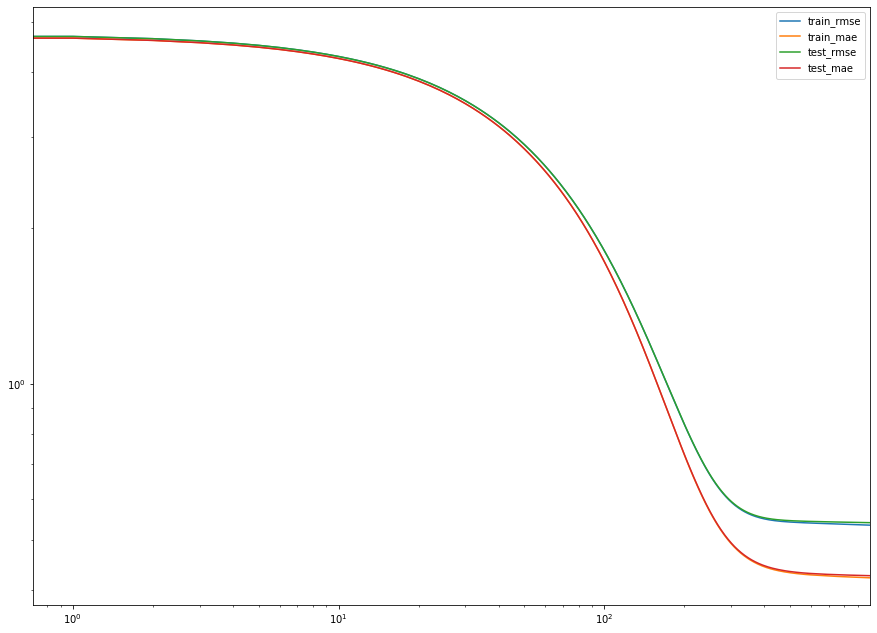

In [23]:
df_eval_results.plot.line(figsize=(15, 11), loglog=True)

In [24]:
y_pred = model.predict(X_test)

In [25]:
df_xgboost_results = get_metrics("xgboost regressor", y_test, y_pred)
df_xgboost_results

,experiment_name,r2_score,explained_variance_score,max_error,mean_absolute_error,mean_squared_error,median_absolute_error
0,xgboost regressor,0.115289,0.115294,2.145184,0.426437,0.291352,0.361008


## Use Linear Regression

In [26]:
lin_model = LinearRegression()

In [27]:
lin_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [28]:
y_pred_lin = lin_model.predict(X_test)

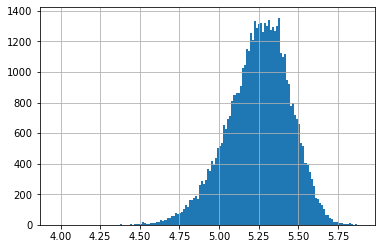

In [29]:
pd.Series(y_pred_lin).hist(bins=150)

In [30]:
df_lin_results = get_metrics("linear regression", y_test, y_pred_lin)
df_lin_results

,experiment_name,r2_score,explained_variance_score,max_error,mean_absolute_error,mean_squared_error,median_absolute_error
0,linear regression,0.110641,0.110659,2.36609,0.426748,0.292883,0.360484


## Baseline

In [31]:
from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin
from sklearn.utils.validation import check_is_fitted


class BaselineModel(BaseEstimator, RegressorMixin):
    def __init__(self):
        pass

    def fit(self, _, y):
        self.mean_ = y.mean()
        return self

    def predict(self, X):
        check_is_fitted(self, [])

        return np.array(X.shape[0] * [self.mean_])

In [32]:
baseline_model = BaselineModel()

In [33]:
baseline_model.fit(X_train, y_train)

BaselineModel()

In [34]:
y_pred_baseline = baseline_model.predict(X_test)

In [35]:
y_pred_baseline

array([5.24764692, 5.24764692, 5.24764692, ..., 5.24764692, 5.24764692,
       5.24764692])

In [36]:
df_baseline_results = get_metrics("baseline", y_test, y_pred_baseline)
df_baseline_results

,experiment_name,r2_score,explained_variance_score,max_error,mean_absolute_error,mean_squared_error,median_absolute_error
0,baseline,-4.660986e-08,0.0,2.001156,0.4577,0.329319,0.392841


## Compare to Baseline

In [37]:
df_results = (
    pd.concat([df_baseline_results, df_xgboost_results, df_lin_results])
    .reset_index(drop=True)
    .T
)
df_results.columns = df_results.loc["experiment_name"].values
df_results = df_results.iloc[1:]

In [38]:
df_results

,baseline,xgboost regressor,linear regression
r2_score,-4.66099e-08,0.115289,0.110641
explained_variance_score,0,0.115294,0.110659
max_error,2.00116,2.14518,2.36609
mean_absolute_error,0.4577,0.426437,0.426748
mean_squared_error,0.329319,0.291352,0.292883
median_absolute_error,0.392841,0.361008,0.360484


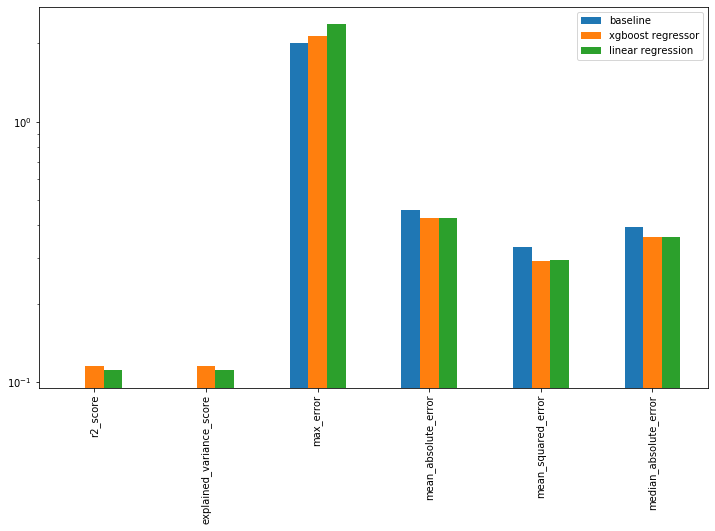

In [39]:
df_results.plot.bar(log=True, figsize=(12, 7))

## Inspect predictions

In [40]:
ylim = (0, 1200)

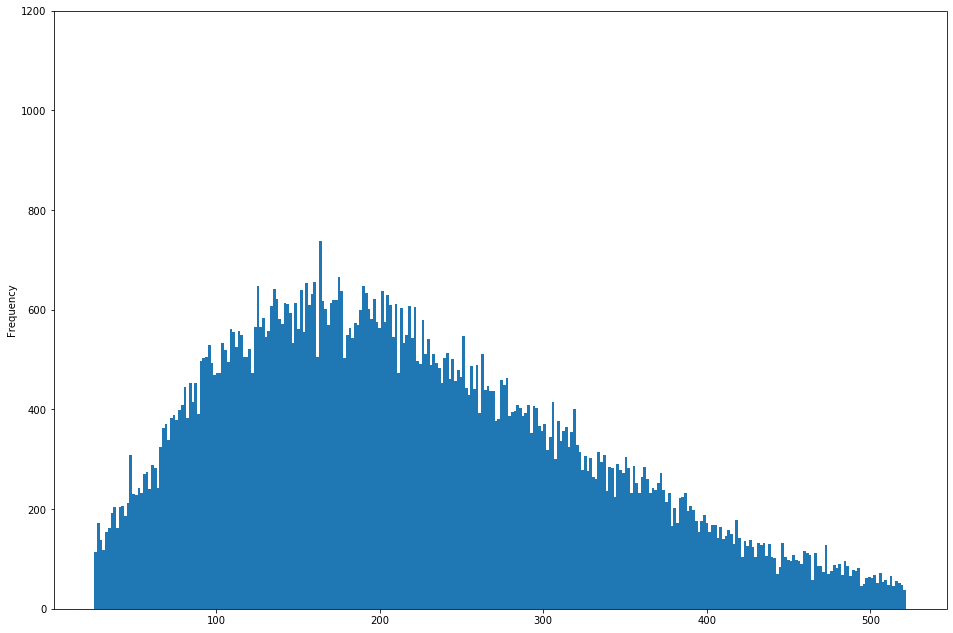

In [41]:
df.iloc[X_train.index].total_calories.plot.hist(bins=300, figsize=(16, 11), ylim=ylim)

In [1]:
df_predictions = df.iloc[X_test.index].assign(predicted_calories=np.exp(y_pred)).sample(5000)

NameError: name 'df' is not defined

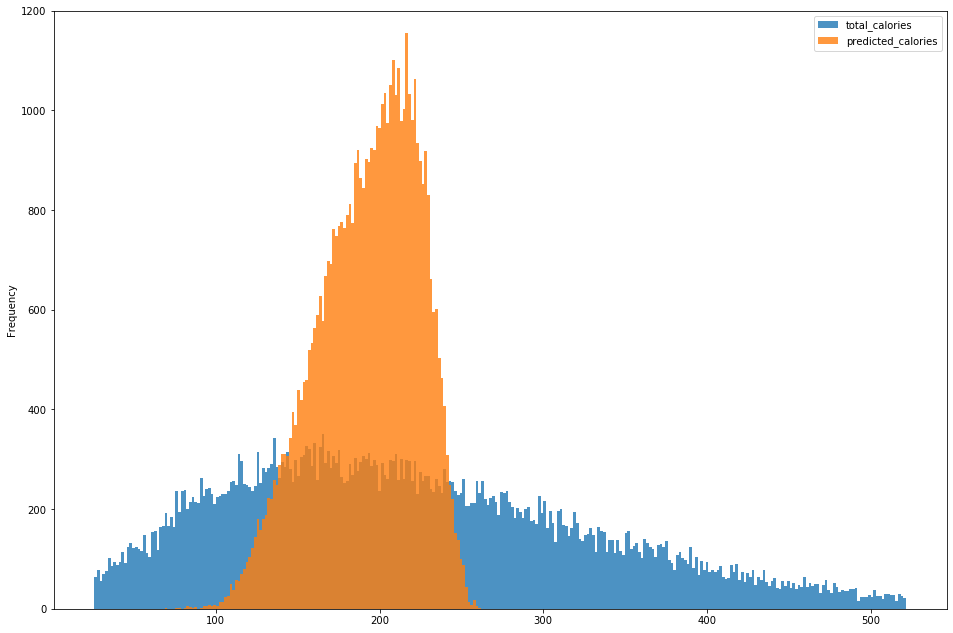

In [43]:
df_predictions[["total_calories", "predicted_calories"]].plot.hist(
    bins=300, figsize=(16, 11), alpha=0.8, ylim=ylim
)

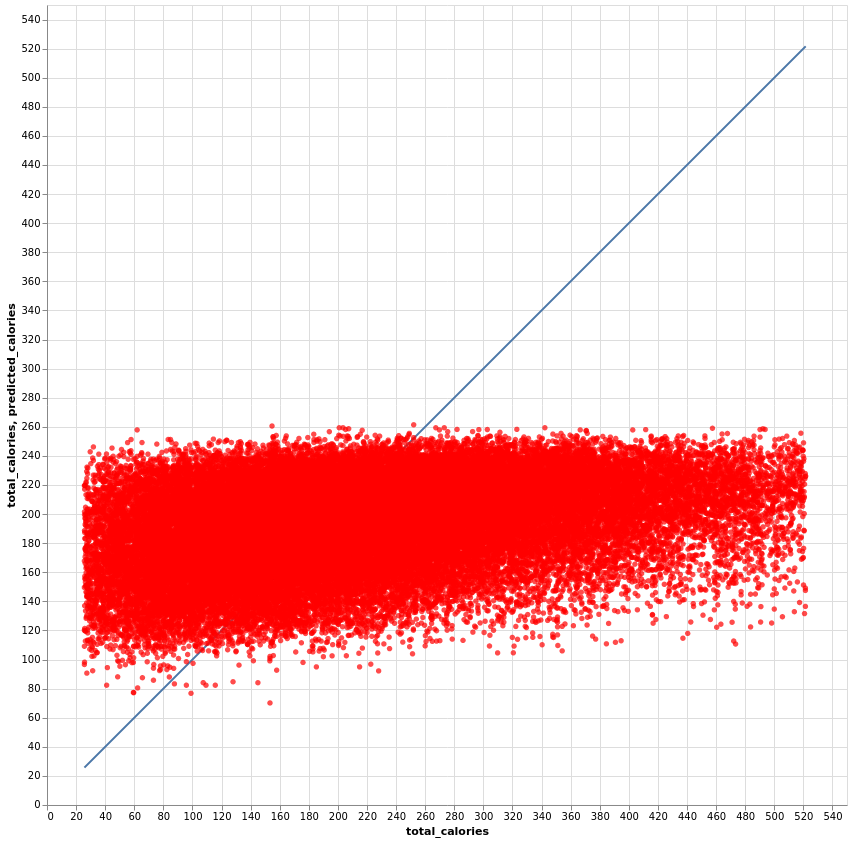

In [44]:
line = (
    alt.Chart(df_predictions).mark_line().encode(x="total_calories", y="total_calories")
)

scatter = (
    alt.Chart(df_predictions)
    .mark_circle(color="red")
    .encode(x="total_calories", y="predicted_calories")
)

(line + scatter).properties(width=800, height=800)

In [45]:
NON_FEATURE_COLS = ["title", "total_calories", "servings", "predicted_calories"]

In [46]:
df_high_cal = df_predictions[df_predictions.predicted_calories > 250]
df_low_cal = df_predictions[df_predictions.predicted_calories < 150]

In [47]:
df_high_cal[NON_FEATURE_COLS].sample(10)

,title,total_calories,servings,predicted_calories
52043,Hamburger Macaroni,434.0,10.0,253.708588
30946,Chicken Spaghetti,490.2,6.0,252.950562
7962,White Bean Chicken Chili,183.4,6.0,254.887939
126725,Mama Mia Meatless Lasagna,252.1,9.0,261.383453
66114,cheesy chicken spaghetti,387.3,6.0,252.950562
77414,bbq chicken casserole (ww),200.6,6.0,254.232803
25567,Cheese and Meet Pasta Bake,296.9,8.0,258.077972
150727,Enchilada Pie,206.8,8.0,251.995636
140925,Chicken Spaghetti,302.7,12.0,258.129303
84030,Verde Chicken Enchiladas,422.4,4.0,251.543869


In [48]:
df_low_cal[NON_FEATURE_COLS].sample(10)

,title,total_calories,servings,predicted_calories
43621,Chick mmm salad,160.5,3.0,123.314827
63985,Green Bean Soup,156.3,2.0,147.398132
136224,Broccoli Salad,221.1,15.0,126.367928
1134,Grilled Asparagus,34.5,2.0,104.730911
143591,Beet-the-Heat Soup,85.4,4.0,128.308044
129388,apple cole slaw,55.5,8.0,113.487183
9246,Jello Pretzel Salad,206.2,16.0,144.901352
128014,Fruit Smoothie,66.1,2.0,132.234238
23986,Mustard Viniagrette,65.1,15.0,122.680649
18443,Home made Hot fudge,77.1,12.0,142.627930


In [49]:
df_high_cal[NON_FEATURE_COLS].describe()

,total_calories,servings,predicted_calories
count,192.000000,192.000000,192.000000
mean,308.658333,7.072917,253.075974
std,102.659146,3.207468,2.577305
min,57.800000,2.000000,250.080841
25%,239.250000,4.000000,251.175568
50%,303.650000,6.000000,252.069740
75%,377.825000,8.000000,253.757431
max,518.300000,20.000000,261.383453


In [50]:
df_low_cal[NON_FEATURE_COLS].describe()

,total_calories,servings,predicted_calories
count,5010.000000,5010.000000,5010.000000
mean,153.147026,6.992016,134.955658
std,89.226535,4.430869,11.751277
min,25.700000,2.000000,70.153908
25%,86.500000,4.000000,127.778605
50%,135.450000,6.000000,137.503754
75%,199.675000,10.000000,144.348541
max,521.400000,23.000000,149.998154


In [51]:
high_cal_wc = WordCloud().generate(" ".join(df_high_cal.title.str.lower()))
low_cal_wc = WordCloud().generate(" ".join(df_low_cal.title.str.lower()))

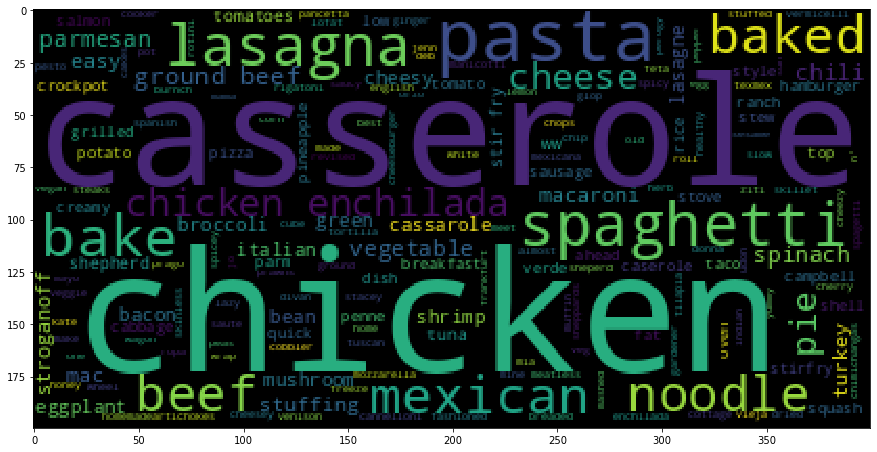

In [52]:
plt.figure(figsize=(15, 15))
plt.imshow(high_cal_wc, interpolation="nearest")

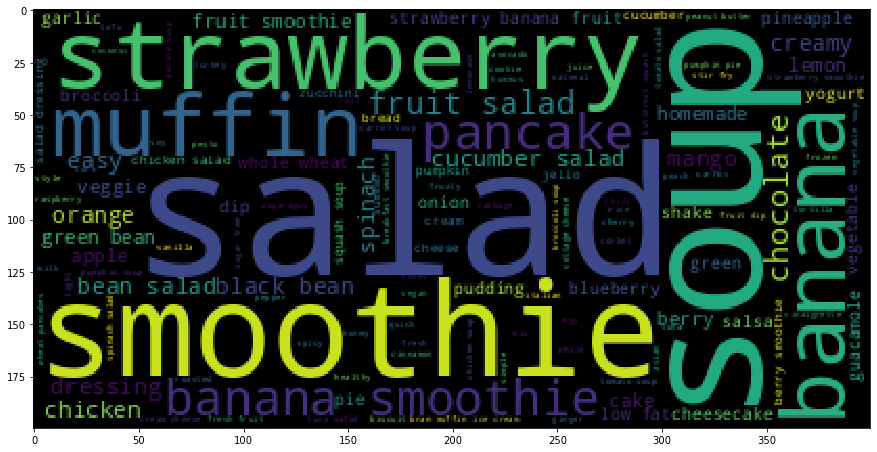

In [53]:
plt.figure(figsize=(15, 15))
plt.imshow(low_cal_wc, interpolation="nearest")